# Section 20.3 Craft a Story From a Dataset - Twitter Bot Detection
    By Caeley Lewis

## Introduction
For this assignment, I have selected the [Twitter-Bot Detection Dataset](https://www.kaggle.com/datasets/goyaladi/twitter-bot-detection-dataset?select=bot_detection_data.csv) from Kaggle.com posted by user ADITYA GOYAL. This dataset was scraped from X formerly known as Twitter and contains the tweet info, the user info, and corresponding labels for whether or not the tweet has been verified to have come from a bot.

Recently, there has been a lot of news on bots on Twitter as a result of Elon Musk's dramatic purchase of Twitter. Long story short, Musk had made public his intention to buy the social media platform, and then backed out of the deal at the last second. His excuse was that he discovered there were more bots on Twitter than he previously imagined, but because his public announcement had already affected other investors and advertisers, the court forced him to follow through with his purchase. Since then, Musk has changed his rhetoric to claim that one of the reasons he bought Twitter in order to crackdown on bots and has taken highly criticized measures to do so, like the pay-to-verify feature. Last June, Musk claimed that 90% of scams had been removed from twitter. A more recent analysis by researchers at Queensland University of Technology as reported by The Guardian suggests otherwise [Bots on X worse than ever according to analysis of 1m tweets during first Republican primary debate](https://www.theguardian.com/technology/2023/sep/09/x-twitter-bots-republican-primary-debate-tweets-increase). 

For the purpose of our assignment, we want to determine what are good predictors of bots on Twitter. 

## Table of Contents

In [87]:
from alive_progress import alive_bar 
from collections import Counter
import language_tool_python
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import LinearSVC
import spacy
import string
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
df = pd.read_csv('data/bot_detection_data.csv')
df.head()

User ID        Username                                              Tweet  \
0   132131           flong  Station activity person against natural majori...   
1   289683  hinesstephanie  Authority research natural life material staff...   
2   779715      roberttran  Manage whose quickly especially foot none to g...   
3   696168          pmason  Just cover eight opportunity strong policy which.   
4   704441          noah87                      Animal sign six data good or.   

   Retweet Count  Mention Count  Follower Count  Verified  Bot Label  \
0             85              1            2353     False          1   
1             55              5            9617      True          0   
2              6              2            4363      True          0   
3             54              5            2242      True          1   
4             26              3            8438     False          1   

       Location           Created At            Hashtags  
0     Adkinston  2020-05-11 15:29:50                 NaN  
1    Sanderston  2022-11-26 05:18:10           both live  
2  Harrisonfurt  2022-08-08 03:16:54         phone ahead  
3  Martinezberg  2021-08-14 22:27:05  ever quickly new I  
4  Camachoville  2020-04-13 21:24:21     foreign mention

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   User ID         50000 non-null  int64 
 1   Username        50000 non-null  object
 2   Tweet           50000 non-null  object
 3   Retweet Count   50000 non-null  int64 
 4   Mention Count   50000 non-null  int64 
 5   Follower Count  50000 non-null  int64 
 6   Verified        50000 non-null  bool  
 7   Bot Label       50000 non-null  int64 
 8   Location        50000 non-null  object
 9   Created At      50000 non-null  object
 10  Hashtags        41659 non-null  object
dtypes: bool(1), int64(5), object(5)
memory usage: 3.9+ MB


In [27]:
df['Created At'] = pd.to_datetime(df['Created At'])

In [5]:
df.describe()

User ID  Retweet Count  Mention Count  Follower Count  \
count   50000.000000    50000.00000   50000.000000    50000.000000   
mean   548890.680540       50.00560       2.513760     4988.602380   
min    100025.000000        0.00000       0.000000        0.000000   
25%    323524.250000       25.00000       1.000000     2487.750000   
50%    548147.000000       50.00000       3.000000     4991.500000   
75%    772983.000000       75.00000       4.000000     7471.000000   
max    999995.000000      100.00000       5.000000    10000.000000   
std    259756.681425       29.18116       1.708563     2878.742898   

          Bot Label                     Created At  
count  50000.000000                          50000  
mean       0.500360  2021-09-14 06:15:49.674619904  
min        0.000000            2020-01-01 00:44:14  
25%        0.000000     2020-11-03 09:24:48.500000  
50%        1.000000            2021-09-16 20:59:38  
75%        1.000000  2022-07-23 02:17:01.750000128  
max        1.000000            2023-05-31 07:53:27  
std        0.500005                            NaN

In [4]:
dt_col_names = ['year','month','day','hour']
dt_col = df['Created At']

dt_cols = pd.DataFrame(np.array([dt_col.dt.year, dt_col.dt.month, dt_col.dt.day, dt_col.dt.hour]).T, columns=dt_col_names)

df_dt_breakdown = pd.concat([df, dt_cols], axis=1)

In [5]:
from ydata_profiling import ProfileReport
from pathlib import Path

profile = ProfileReport(df=df_dt_breakdown, config_file='profiling-config/config_default.yaml')

In [6]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [102]:
bots_over_time = df[['Created At', 'Bot Label']].set_index('Created At').sort_values(by='Created At')

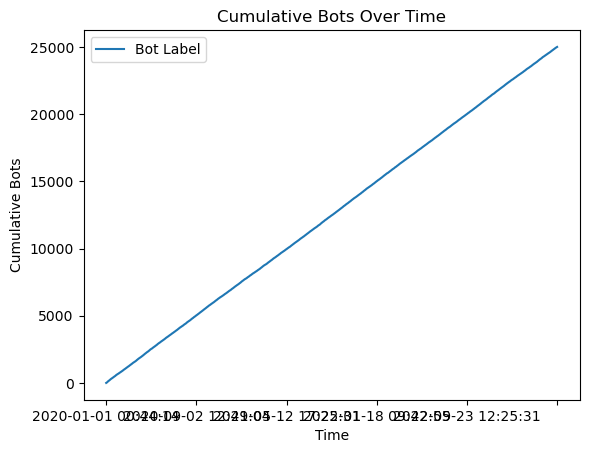

In [103]:
bots_over_time.cumsum().plot()
plt.title('Cumulative Bots Over Time')
plt.xlabel('Time')
plt.ylabel('Cumulative Bots')
plt.show()

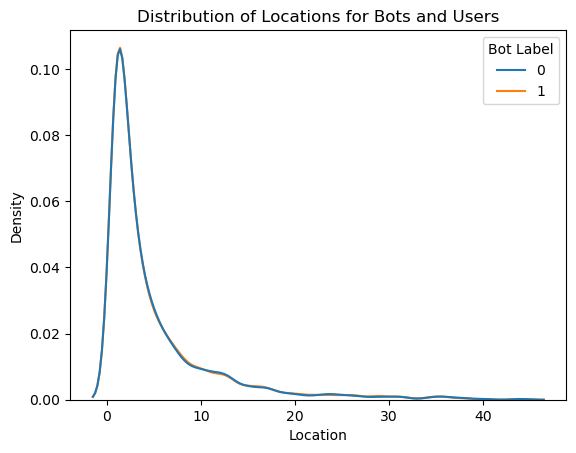

0.00033724507974514973


In [104]:
loc_val_counts = df['Location'].value_counts()

loc_counts_sers = df['Location'].map(loc_val_counts)

sns.kdeplot(x=loc_counts_sers, hue=df['Bot Label'])
plt.title('Distribution of Locations for Bots and Users')
plt.show()
print(loc_counts_sers.corr(df['Bot Label']))

From this we determine that this dataset has been highly manicured so that it is very pretty. The Bot label is split almost precisely 50-50. All other features have been split and selected so that they are very even. Plus, they have almost zero correlation with each other. Even after breaking down the datetime object into its components, there is almost zero correlation. Furthermore, after sorting the data by their timestamps and adding up the number of bots labeled over time, we observe a nearly perfect linear relationship. There is no realistic way that this would actually happen in real life. This is great data to use to develop a machine learning algorithm because we can be fairly certain our features are independent, but it's certainly not representative of what Twitter looks like.

Let's continue with some analysis of the text features

In [3]:
nlp = spacy.load('en_core_web_sm')
punct = string.punctuation
stoplist = set(stopwords.words('english') + list(ENGLISH_STOP_WORDS))
excluded_ents = ['ORDINAL', 'CARDINAL']

def process_text(docs):
    clean_texts = [''] * len(docs)
    doc_entities = [''] * len(docs)
    
    for i, doc in enumerate(nlp.pipe(docs)):
        clean_texts[i] = clean_text(doc)
        doc_entities[i] = extract_entities(doc)
    
    return pd.Series(clean_texts), pd.Series(doc_entities)
        
def clean_text(doc):
    tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
    tokens = [tok for tok in tokens if tok not in stoplist and tok not in punct]
    
    return ' '.join(tokens)

def extract_entities(doc):
    return ' '.join([ent.text for ent in doc.ents if ent.label_ not in excluded_ents])

def find_most_common(text_series, num_most_common=20):
    joined_list = ' '.join(text_series).split()
    counts = Counter(joined_list)
    return counts.most_common(num_most_common)

def show_most_common(most_common_object, title):
    plt.figure(figsize=(18,6), dpi=100)
    words = [tple[0] for tple in most_common_object]
    instances = [tple[1] for tple in most_common_object]
    sns.barplot(x=words, y=instances)
    plt.title(title)
    plt.xlabel('Words')
    plt.xticks(rotation=45)
    plt.ylabel('Instances')
    plt.show()

In [74]:
bot_docs = df.loc[df['Bot Label'] == 1, 'Tweet']
user_docs = df.loc[df['Bot Label'] == 0, 'Tweet']

bot_texts, bot_ents = process_text(bot_docs)
user_texts, user_ents = process_text(user_docs)

bot_text_most_common = find_most_common(bot_texts)
bot_ents_most_common = find_most_common(bot_ents)

user_text_most_common = find_most_common(user_texts)
user_ents_most_common = find_most_common(user_ents)

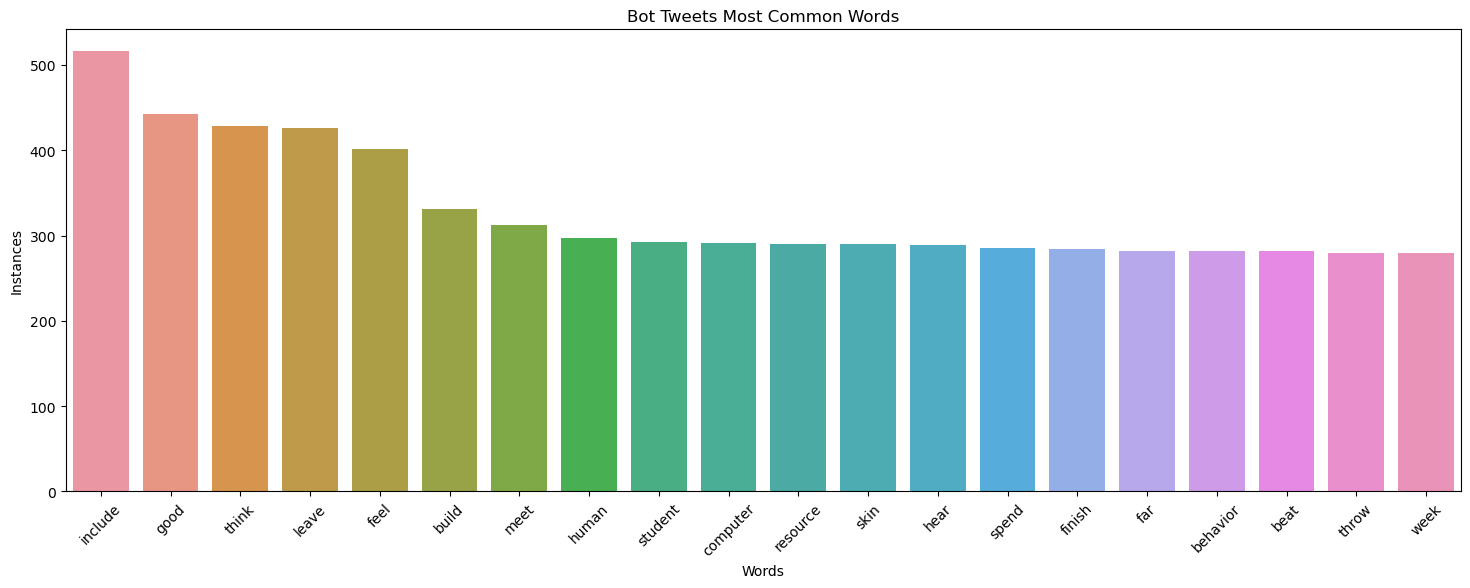

In [45]:
show_most_common(bot_text_most_common, 'Bot Tweets Most Common Words')

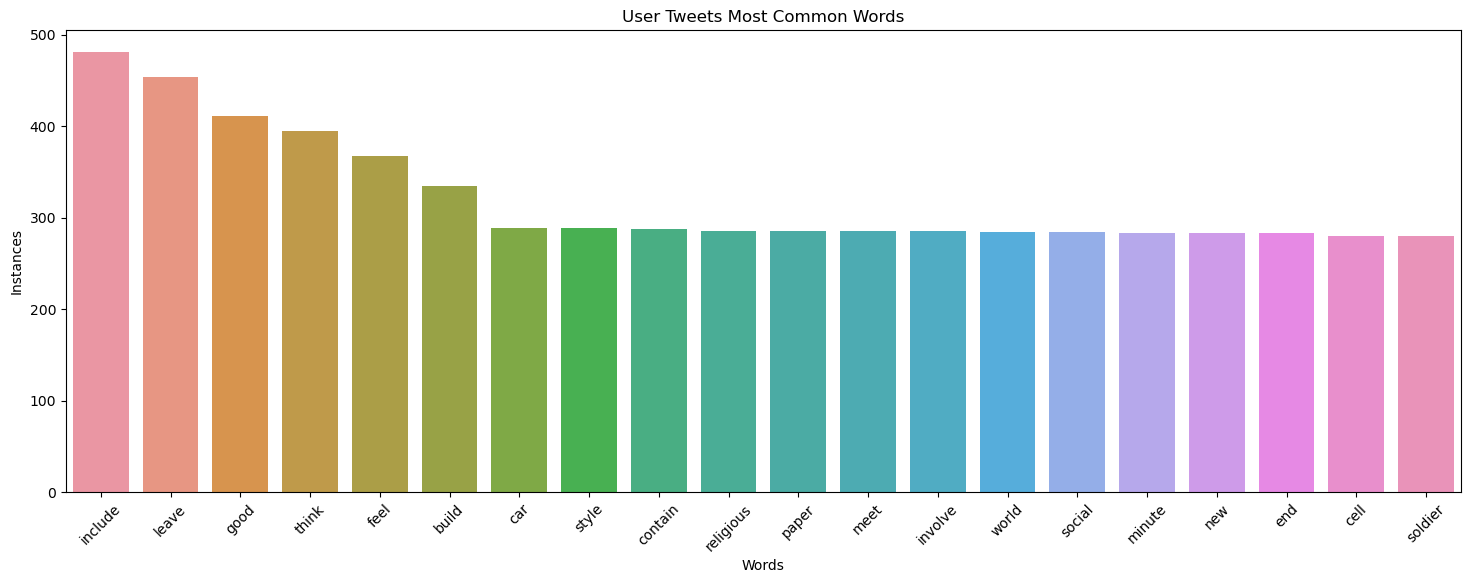

In [46]:
show_most_common(user_text_most_common, 'User Tweets Most Common Words')

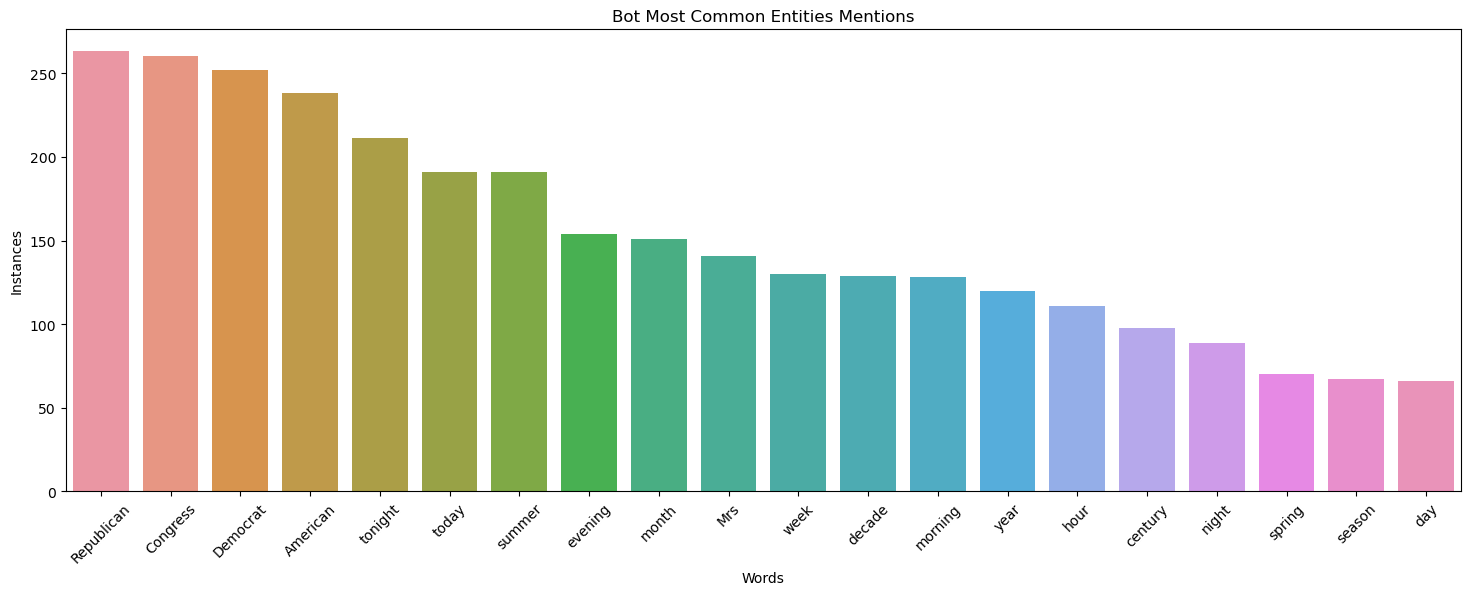

In [75]:
show_most_common(bot_ents_most_common, 'Bot Most Common Entities Mentions')

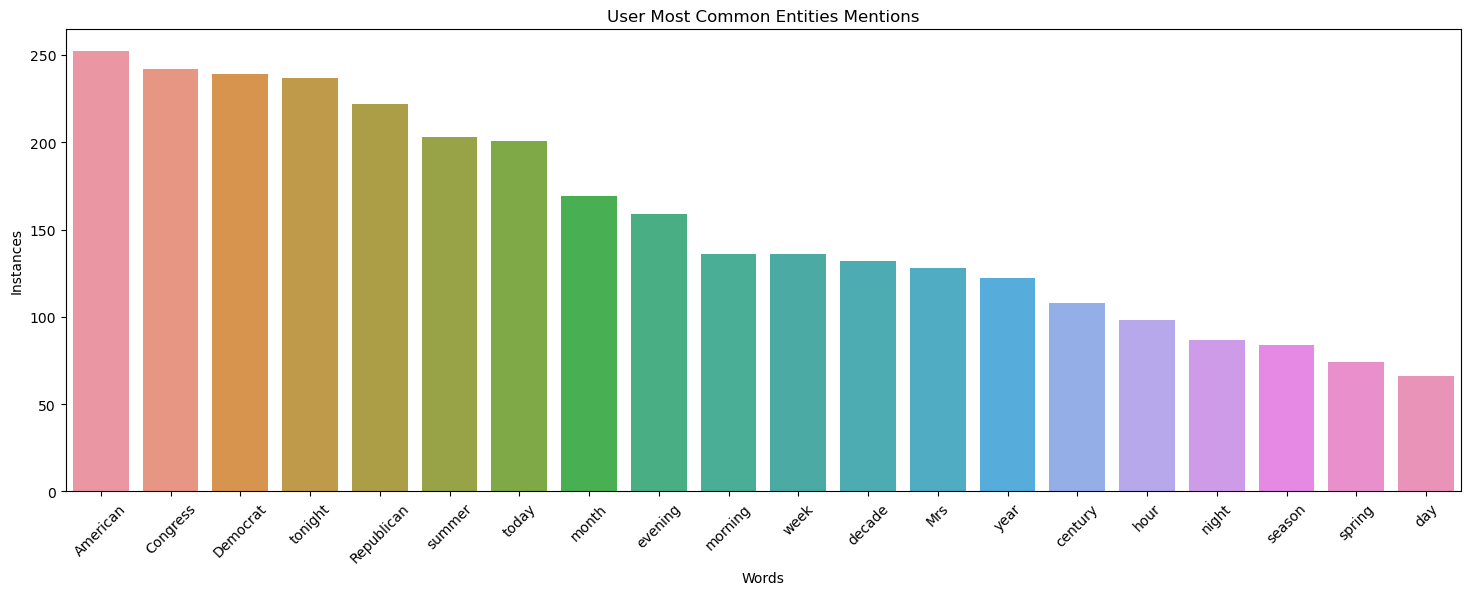

In [76]:
show_most_common(user_ents_most_common, 'User Most Common Entities Mentions')

In [39]:
bot_common_hashtags = df.loc[df['Bot Label'] == 1, 'Hashtags'].fillna('NaN') \
    .value_counts() \
    .sort_index() \
    .sort_values(ascending=False, kind='mergesort') \
    .head(21)
user_common_hashtags = df.loc[df['Bot Label'] == 0, 'Hashtags'].fillna('NaN') \
    .value_counts() \
    .sort_index() \
    .sort_values(ascending=False, kind='mergesort') \
    .head(21)

print(f'The number of missing hashtags for bots is {bot_common_hashtags[0]} and {user_common_hashtags[0]} is for users.')

The number of missing hashtags for bots is 4180 and 4161 is for users.


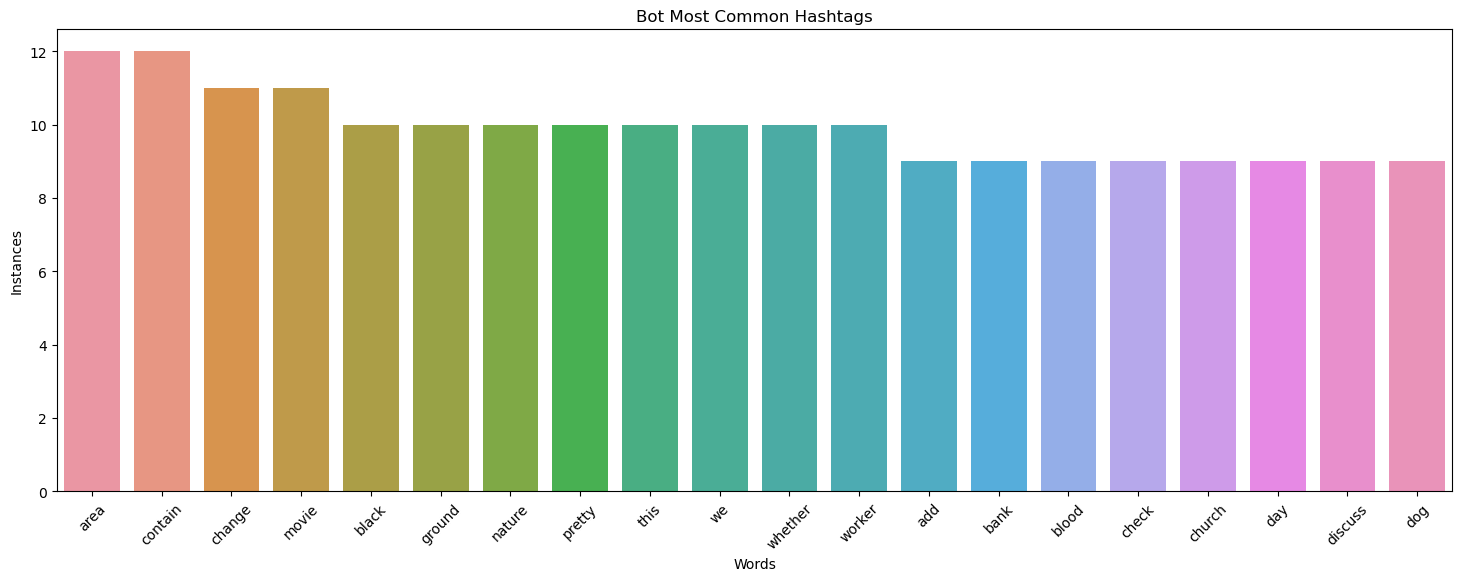

In [38]:
plt.figure(figsize=(18,6), dpi=100)
sns.barplot(x=bot_common_hashtags[1:].index, y=bot_common_hashtags[1:].values)
plt.title('Bot Most Common Hashtags')
plt.xlabel('Words')
plt.xticks(rotation=45)
plt.ylabel('Instances')
plt.show()

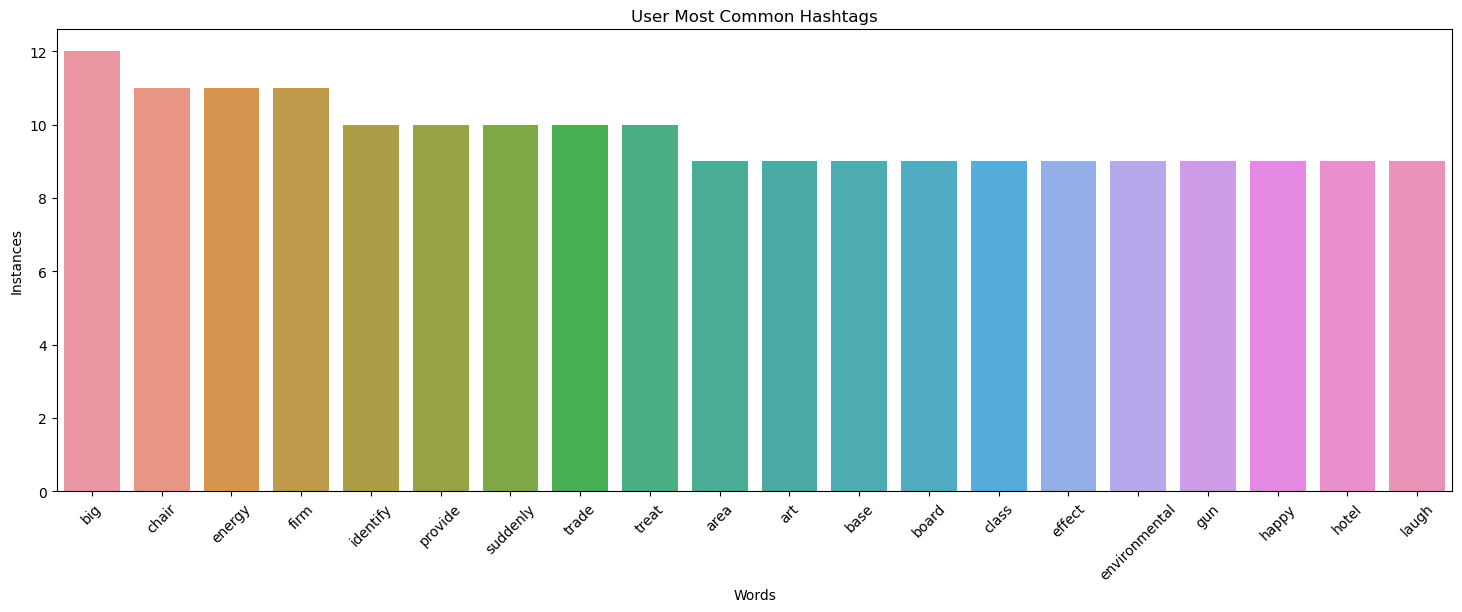

In [40]:
plt.figure(figsize=(18,6), dpi=100)
sns.barplot(x=user_common_hashtags[1:].index, y=user_common_hashtags[1:].values)
plt.title('User Most Common Hashtags')
plt.xlabel('Words')
plt.xticks(rotation=45)
plt.ylabel('Instances')
plt.show()

Hashtags appear like they could have some meaningful differences considering there are no similarities

In [4]:
tool = language_tool_python.LanguageTool('en-US')

In [6]:
find_num_grammar_errs = np.vectorize(lambda x: len(tool.check(x)))

n = 20
chunks = np.linspace(0, len(df)-1, n).astype('int')
assert(chunks[-1] == len(df) - 1)
grammar_errors = np.zeros(len(df))

with alive_bar(n-1, force_tty=True) as bar:
    for i in range(n - 1):
        grammar_errors[chunks[i]:chunks[i+1]] = find_num_grammar_errs(df['Tweet'][chunks[i]:chunks[i+1]])
        bar()

|██████████████████████████████████████⚠︎ | (!) 19/20 [95%] in 53:24.5 (0.01/s)  


In [90]:
df['Grammar Errors'] = grammar_errors

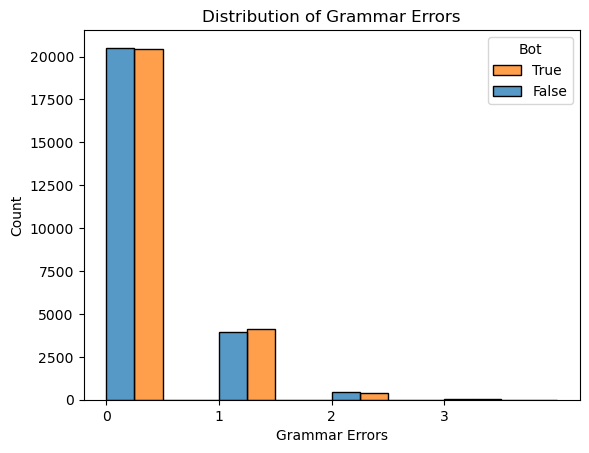

In [97]:
plt.figure(dpi=100)
sns.histplot(data=df, x='Grammar Errors', hue='Bot Label', bins=np.arange(0, max(grammar_errors)), multiple='dodge', binwidth=0.5)
plt.xticks(np.arange(0, max(grammar_errors)))
plt.legend(title='Bot', labels=['True','False'])
plt.title('Distribution of Grammar Errors')
plt.show()

In [57]:
df.to_csv('data/final_data.csv')

In [48]:
X = df.drop(['User ID', 'Username', 'Location', 'Bot Label'], axis=1)
y = df['Bot Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_holdout, y_test, y_holdout = train_test_split(X_test, y_test, test_size=0.33, random_state=42)

In [67]:
class DatetimeFeatureExtractor(BaseEstimator, TransformerMixin):
    col_names = ['year', 'month', 'day', 'hour']
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        dt_x = pd.to_datetime(X)
        return pd.DataFrame(np.array([dt_x.dt.year, dt_x.dt.month, dt_x.dt.day, dt_x.dt.hour]).T, columns=self.col_names)

class StringNAFiller(BaseEstimator, TransformerMixin):
    na_replacement = 'NaN'
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.fillna(self.na_replacement)

parser = spacy.lang.en.English()
def tokenizeText(sample):
    tokens = list(parser(sample))
    i=0
    while i < len(tokens):
        tok = tokens[i]
        if tok.lemma_ != '-PRON-':
            tok = tok.lemma_.lower().strip()
        else:
            tok = tok.lower_
        if tok in stoplist:
            tokens.pop(i)
            continue
        tokens[i] = tok
        i += 1
        
    return tokens

In [79]:
column_trans = ColumnTransformer(transformers=[('tweet_bow', TfidfVectorizer(tokenizer=tokenizeText, ngram_range=(1,1)), 'Tweet'),
                                               ('hashtag_ohe', OneHotEncoder(handle_unknown='ignore'), ['Hashtags']),
                                               ('createdat_dt', DatetimeFeatureExtractor(), 'Created At')],
                                 remainder='passthrough',
                                 verbose_feature_names_out=False)

pipeline = Pipeline([
    ('transformer', column_trans),
    ('clf', MultinomialNB())
])

In [88]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tweet_bow',
                                                  TfidfVectorizer(tokenizer=<function tokenizeText at 0x0000021179B8A050>),
                                                  'Tweet'),
                                                 ('hashtag_ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Hashtags']),
                                                 ('createdat_dt',
                                                  DatetimeFeatureExtractor(),
                                                  'Created At')],
                                   verbose_feature_names_out=False)),
                ('clf', MultinomialNB())])

In [81]:
preds = pipeline.predict(X_test)

In [82]:
accuracy_score(y_test, preds)

0.49711442786069654

In [83]:
confusion_matrix(y_test, preds)

array([[2493, 2513],
       [2541, 2503]], dtype=int64)